# Used Packages

In [1]:
import os
import shutil
import random

import pandas as pd
import spacy
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization

import matplotlib.pyplot as plt
import matplotlib

# Model Creation

In [2]:
PATH = 'data'
# set this parameter if you want to train another model
TRAIN_NEW_MODEL = False
NEW_MODEL_NAME = 'imdb2'

##  Dataset

In [3]:
# downloading the imdb dataset (if not already done)
# removing the unnecessary unsup folder because this is a supervised ml task
if not os.path.isdir('data'):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True, cache_dir=PATH,
                                        cache_subdir='')

    shutil.rmtree('unsup')

In [4]:
# setting the directory for the training and test data
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

### Dataset Parameters

In [5]:
# setting model parameters
# autotune allows the automatic setting of the number of prefetched data ahead
# of time they are requested in the learning process
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
epochs = 1
seed = 42
init_lr = 3e-5

### Splitting Dataset

In [6]:
# training set 80 percent of all files with 20 left for validation
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Model Training

In [7]:
if TRAIN_NEW_MODEL:
    # setting the bert encoder and preprocessor
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

    # generating the bert encoder and preprocess layer for the model
    # (save model error can be fixed by deleting temp folder)
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    # function for building the classifiert model 
    # text input -> preprocessing -> encode -> droput -> dense 

    def build_classifier_model():
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
        return tf.keras.Model(text_input, net)

    # initialize classifier model
    classifier_model = build_classifier_model()

    # set loss and metric functions
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    # create model hyperparameter optimizer
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

    # early stopping 
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss')

    # compile the model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    # train the model
    history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)

In [8]:
if TRAIN_NEW_MODEL:
    loss, accuracy = classifier_model.evaluate(test_ds)

In [9]:
if TRAIN_NEW_MODEL:
    saved_model_path = f'./models/{NEW_MODEL_NAME}_bert'
    classifier_model.save(saved_model_path, include_optimizer=False)

# Loading the model and working with it

In [10]:
if not TRAIN_NEW_MODEL:
    saved_model_path = f'models/{os.listdir("models")[1]}'
    model = tf.keras.models.load_model(saved_model_path, compile=False)
else: 
    model = classifier_model

## Get complete test data

In [11]:
test_data_unbatched = list(test_ds.unbatch().as_numpy_iterator())

## Select random pair

In [104]:
rand_ind = random.randint(0, len(test_data_unbatched))
rand_sen_label_pair = test_data_unbatched[rand_ind]
rand_sen_label_pair[0]

b'Someone definitely has it in for The Wind and I cannot believe that what I saw on the screen has much to do with it. This is a better and more solid movie than most of the independents I watch all year long. The cinematography displays a genuine love and mastery of the craft and the casting was just fine. I would love to see more of these folks, especially Zeke Rippy.<br /><br />As far as the story and script, I\'m not so sure that the negative comments preceding this post were written with the intent of informing anybody else about the movie. The long drawn out nit-picky bashing posts that must have taken hours to compose and are the only comments ever left for any movie on this site by the reviewer, are obvious slander directed at the producers of the film. I don\'t know the inside story, but it would probably make a good movie. What I do know from being around this biz, is, productions that try to make everybody happy usually end up being awful and when the filmmaker has the guts,

In [105]:
#function to classify a text given a model

def classify_text(model, text, parent_ind=None, child_ind=None):
    score = tf.sigmoid(model(tf.constant([text])))[0][0].numpy()
    pred_label = np.where(score > 0.5, 1, 0).item()

    if parent_ind or child_ind:
        return (score, pred_label, parent_ind, child_ind)
    else:
        return (score, pred_label)

## Predict random pair

In [106]:
org_text_pred = classify_text(model, rand_sen_label_pair[0])
print(f'Predicted Label: {org_text_pred[1]} \nScore: {org_text_pred[0]} \nReal Label: {rand_sen_label_pair[1]}')

Predicted Label: 1 
Score: 0.9988898634910583 
Real Label: 1


## Dependecy Parser

In [107]:
depend_parser = spacy.load('en_core_web_sm')

In [108]:
parsed_text = depend_parser(str(rand_sen_label_pair[0]))
sentence_spans = list(parsed_text.sents)[0]

In [109]:
spacy.displacy.render(sentence_spans, jupyter=True, options={"compact": True})

## Leave-n-out,leave-one-out, strength calculation and linearization

In [110]:
# leave n out function
# go over all tokens, if a token has children, then for every token children pair
# return a text with both removed
def leave_n_out(parsed_text):
    new_texts = []
    for token in parsed_text:
        if token.children:
            for child in token.children:
                new_text = []

                for item in parsed_text:
                    if item.i == token.i or item.i == child.i:
                        pass
                    else:
                        new_text.append(item.text)

                new_texts.append((" ".join(new_text), token.i, child.i))

    return new_texts

In [111]:
# leave one out function
# go over all tokens, for every token 
# return a text with it removed
def leave_one_out(parsed_text):
    new_texts = []
    for token in parsed_text:
        new_text = []

        for item in parsed_text:
            if item.i == token.i:
                pass
            else: 
                new_text.append(item.text)

        new_texts.append((" ".join(new_text), token.i))

    return new_texts
        

In [112]:
new_texts_lno = leave_n_out(parsed_text)
new_texts_loo = leave_one_out(parsed_text)

### Process leave-n-out texts

#### Create dataframe

In [113]:
# df of all created texts with leave-n-out, with Score, predicted label, parent index and child index
df_lno = pd.DataFrame([
    classify_text(
        model, text_triple[0], text_triple[1], text_triple[2])
    for text_triple in new_texts_lno],
    columns=['Score',
             'Predicted Label',
             'Parent Index',
             'Child Index'])

df_lno


,Score,Predicted Label,Parent Index,Child Index
0,0.999025,1,2,0
1,0.998396,1,2,1
2,0.998446,1,2,3
3,0.998524,1,2,4
4,0.998565,1,2,5
...,...,...,...,...
544,0.997763,1,560,559
545,0.997763,1,562,563
546,0.997763,1,562,565
547,0.997763,1,565,564


#### Drop all word pairs not contributing to prediction

In [114]:
# removes all texts which had the same Score or better with the word pair removed
# thus not contributing to the prediction
if org_text_pred[1] == 1:
    df_lno = df_lno.drop(df_lno.index[df_lno['Score'] >= org_text_pred[0]] )
else:
    df_lno = df_lno.drop(df_lno.index[df_lno['Score'] <= org_text_pred[0]] )

#### Calculate Score Difference

In [115]:
# adds a new column Score Difference which captures the difference of the new text prediction and the original
if org_text_pred[1] == 1:
    df_lno['Score Difference'] = org_text_pred[0] - df_lno['Score']
else:
    df_lno['Score Difference'] = df_lno['Score'] - org_text_pred[0]

#### Linearize the Score Difference

In [116]:
df_lno_copy = df_lno.copy()
df_lno_copy[['Child Index', 'Parent Index']] = df_lno[['Parent Index', 'Child Index']]
df_lno = pd.concat([df_lno, df_lno_copy]).reset_index(drop=True)
df_lno.drop(["Score", "Predicted Label", "Child Index"], inplace=True, axis=1)
df_lno = df_lno.loc[df_lno.groupby(['Parent Index'])["Score Difference"].idxmax()]
df_lno['Score Difference'] = MinMaxScaler().fit_transform(df_lno[['Score Difference']])
df_lno = df_lno.sort_values(by=['Score Difference'])
df_lno.rename(columns={"Parent Index": "Token Index"}, inplace=True)
df_lno

,Token Index,Score Difference
600,57,0.000000
58,62,0.000037
605,61,0.000037
557,11,0.000195
627,84,0.000254
...,...,...
575,31,0.035019
25,28,0.084738
572,27,0.084738
576,33,1.000000


### Process leave-one-out texts

#### Create dataframe

In [117]:
df_loo = pd.DataFrame([
    classify_text(
        model, text_tuple[0])
    for text_tuple in new_texts_loo],
    columns=['Score',
             'Predicted Label'])

#### Drop all word pairs not contributing to prediction

In [118]:
# removes all texts which had the same Score or better with the word pair removed
# thus not contributing to the prediction
if org_text_pred[1] == 1:
    df_loo = df_loo.drop(df_loo.index[df_loo['Score'] >= org_text_pred[0]] )
else:
    df_loo = df_loo.drop(df_loo.index[df_loo['Score'] <= org_text_pred[0]] )

#### Calculate Score Difference and Linearize

In [119]:
df_loo.reset_index(inplace=True)
df_loo.rename(columns={'index':'Token Index'}, inplace=True) 

if org_text_pred[1] == 1:
    df_loo['Score Difference'] = org_text_pred[0] - df_loo['Score']
else:
    df_loo['Score Difference'] = df_loo['Score'] - org_text_pred[0]

df_loo['Score Difference'] = MinMaxScaler().fit_transform(df_loo[['Score Difference']])
df_loo

,Token Index,Score,Predicted Label,Score Difference
0,0,0.998871,1,0.000000
1,1,0.997678,1,0.092831
2,2,0.997961,1,0.070811
3,3,0.997776,1,0.085202
4,4,0.997845,1,0.079879
...,...,...,...,...
564,564,0.997763,1,0.086255
565,565,0.997763,1,0.086255
566,566,0.997763,1,0.086255
567,567,0.997763,1,0.086255


### Create Colormap 

In [120]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cornflowerblue","lime"], gamma=0.75)

# Visualize Texts

In [121]:
def vis_text(df):
    start_x = 20
    start_y = 500
    end = 1200
    whitespace = 8

    figure = plt.figure(figsize=(20, 10))
    rend = figure.canvas.get_renderer()

    for token in parsed_text:
        if df.loc[df["Token Index"] == token.i, 'Score Difference'].values.size > 0:
            col = cmap(df.loc[df["Token Index"] == token.i, 'Score Difference'].values[0])
        else: 
            col = "white"
        bbox = dict(boxstyle="round,pad=0.3", fc=col, ec="white")

        # Check if word contains "foot", "feet", "foot." or "feet." or caps locked.
        # Depending what you are trying to achieve.
        txt = plt.text(start_x, start_y, str(token), bbox=bbox, transform=None)
        # Textbox width
        bb = txt.get_window_extent(renderer=rend)

        # Calculate where next word should be written
        start_x = bb.width + start_x + whitespace

        # Next line if end parameter in pixels have been crossed
        if start_x >= end:
            start_x = 20
            start_y -= 20

    plt.axis("off")
    plt.show()

Leave n out:


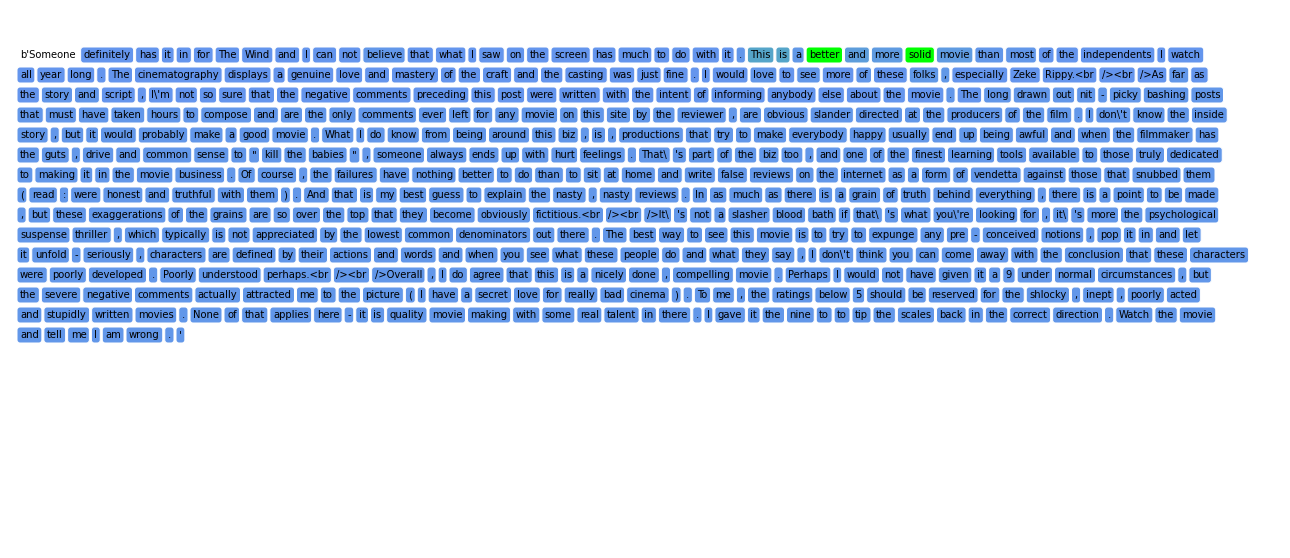

Leave one out:


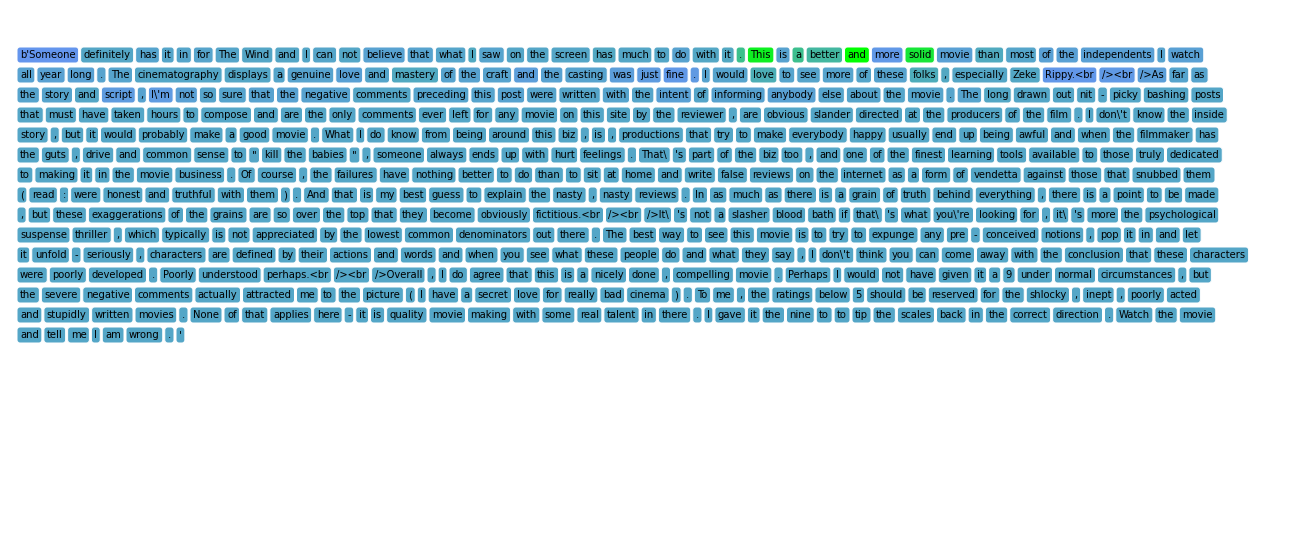

In [122]:
print('Leave n out:')
vis_text(df_lno)
print('Leave one out:')
vis_text(df_loo)